In [371]:
# Importar o componente que retornará informarções de uma ação da bolsa de valores
from yahooquery import Ticker
# Componentes de analise
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import requests
from pandas import json_normalize
import pandas as pd
import math



In [372]:
# Vamos fazer uma analise PETR4 (Petrobrás)
petr = Ticker("PETR4.SA")
petr_dados = petr.history(period="max")
petr_dados.index = petr_dados.index.unique(level='date')
petr_dados.index = pd.to_datetime(petr_dados.index)




In [373]:
petr_dados.head()

,low,high,volume,close,open,adjclose,dividends,splits
date,,,,,,,,
2000-01-03,5.875,5.875,3.538944e+10,5.875,5.875,2.139587,0.0,0.0
2000-01-04,5.550,5.550,2.886144e+10,5.550,5.550,2.021227,0.0,0.0
2000-01-05,5.494,5.494,4.303360e+10,5.494,5.494,2.000833,0.0,0.0
2000-01-06,5.475,5.475,3.405568e+10,5.475,5.475,1.993914,0.0,0.0
2000-01-07,5.500,5.500,2.091264e+10,5.500,5.500,2.003018,0.0,0.0


<AxesSubplot: xlabel='date'>

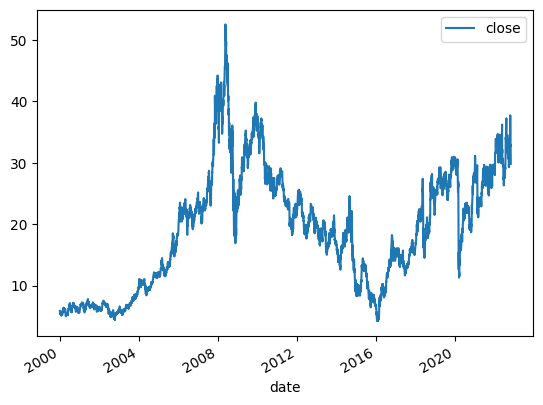

In [374]:
# Verificar a ação desde 2000
petr_dados[["close"]].plot()

<AxesSubplot: xlabel='date'>

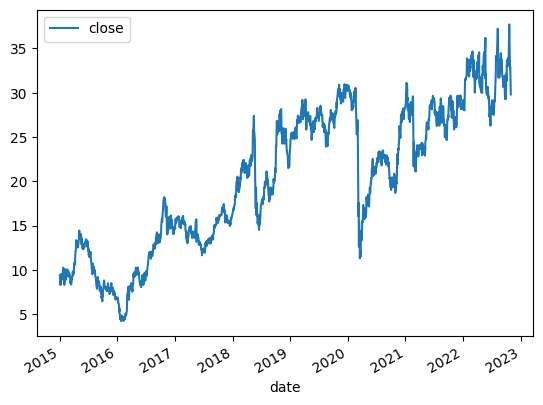

In [375]:
# Verificar a ação a partir 2015
petr_dados[petr_dados.index >= pd.to_datetime('2015-01-01')][["close"]].plot()

<AxesSubplot: xlabel='date'>

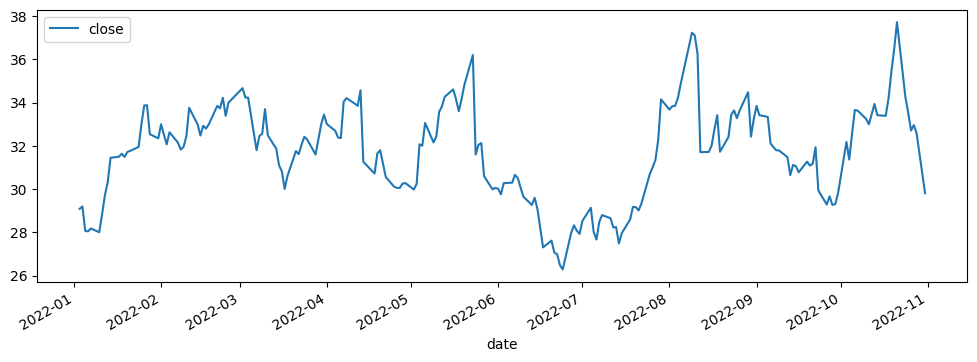

In [376]:
# Verificar a ação esse ano
fig, axs = plt.subplots(figsize=(12, 4))

petr_dados[petr_dados.index >= pd.to_datetime('2022-01-01')][["close"]].plot(ax=axs)

'----'

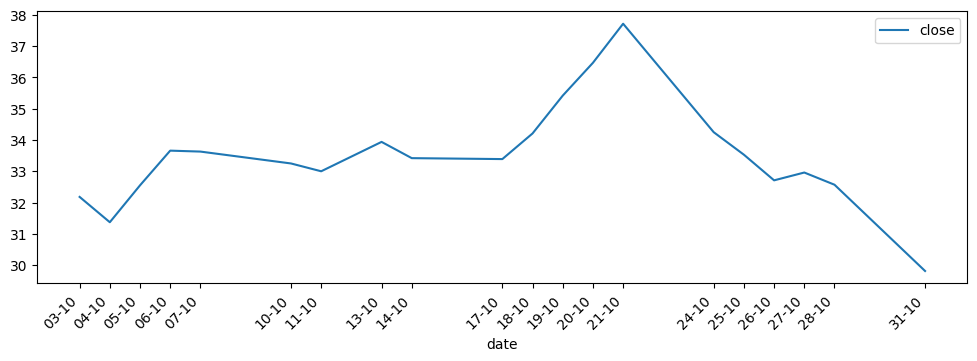

In [377]:
# Verificar o comportamento da ação no ultimo mês

fig, axs = plt.subplots(figsize=(12, 4))
dados_plot = petr_dados[petr_dados.index >= pd.to_datetime((datetime.now() - relativedelta(months=1)))][["close"]]
plot = dados_plot.plot(ax=axs)
x_labels = pd.to_datetime(dados_plot.index).strftime('%d-%m')


plot.set_xticks(dados_plot.index)
plot.set_xticklabels(x_labels, rotation=45)

"----"


In [378]:
# Analisar a base da SELIC

r = requests.get('https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json')
retorno_api = r.json()

dt_selic = json_normalize(retorno_api) 
dt_selic



,data,valor
0,04/06/1986,0.065041
1,05/06/1986,0.067397
2,06/06/1986,0.066740
3,09/06/1986,0.068247
4,10/06/1986,0.067041
...,...,...
9122,25/10/2022,0.050788
9123,26/10/2022,0.050788
9124,27/10/2022,0.050788
9125,28/10/2022,0.050788


In [379]:
# Transformar o retorno da API em uma série, pra se adaptar ao dataset da ação e para que possamos fazer algumas analises 

def converterDataObj(x):
    return datetime.strptime(x, "%d/%m/%Y")
dt_selic["valor"].index = dt_selic["data"].apply(converterDataObj)
dt_selic["valor"].index.names = ['date']

selic = pd.Series(dt_selic["valor"])
#Converter valores pra float

selic = pd.to_numeric(selic)
selic

date
1986-06-04    0.065041
1986-06-05    0.067397
1986-06-06    0.066740
1986-06-09    0.068247
1986-06-10    0.067041
                ...   
2022-10-25    0.050788
2022-10-26    0.050788
2022-10-27    0.050788
2022-10-28    0.050788
2022-10-31    0.050788
Name: valor, Length: 9127, dtype: float64

In [380]:
# Filtrar para apenas nos anos 2000 pra cima, pois é onde se inicia nosso dataset

selic = selic[selic.index >= pd.to_datetime('2000-01-01')]

<AxesSubplot: xlabel='date'>

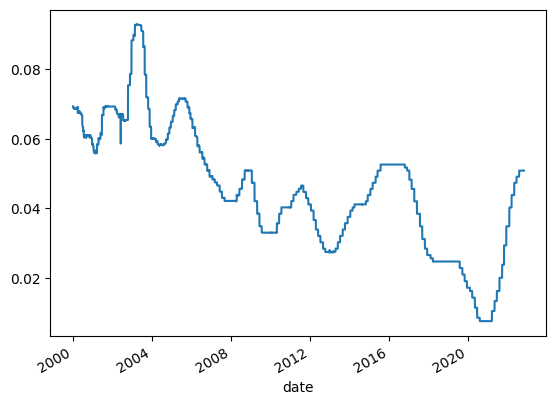

In [381]:
# Verificar o comportamento da SELIC durante os anos 

selic.plot()

In [382]:
# Unir selic com a base PETR4 

petr_dados = petr_dados.assign(selic = selic)

# Verificar se algum ficou em branco 

petr_dados.isna().sum()


low           0
high          0
volume        0
close         0
open          0
adjclose      0
dividends     0
splits        0
selic        62
dtype: int64

In [383]:
# verifiquei que será melhor fazer a predição dos ultimos dois anos, pois é onde houve uma oscilação menor 

petr_dados = petr_dados[petr_dados.index >= pd.to_datetime('2020-01-01')]


In [384]:
# Os em branco vou preencher com o ultimo valor

def preencherUltimoSelic (x):
     
    global selic     
    days = 1   
   
    while math.isnan(x['selic']):
        atual = pd.to_datetime(x.name - relativedelta(days=days)).strftime('%Y-%m-%d')
        if atual in selic.index :
            x['selic'] = selic.loc[atual]                  
        days += 1
    return x

selic_preenchidos = petr_dados[petr_dados["selic"].isna()].apply(preencherUltimoSelic, axis=1)

# depois que descobri os valores anteriores, vou preenchelos na base final

for index,value in selic_preenchidos.iterrows() :    
    petr_dados["selic"][index] = value['selic']

# por fim verificar se não há mais valores nulos

petr_dados.isna().sum()

low          0
high         0
volume       0
close        0
open         0
adjclose     0
dividends    0
splits       0
selic        0
dtype: int64

In [385]:
# Verificar correlação entre as colunas 

corr = petr_dados.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)


C:\Users\gabri\AppData\Local\Temp\ipykernel_21936\682635969.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)
c:\Python310\lib\site-packages\pandas\io\formats\style.py:3925: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Python310\lib\site-packages\pandas\io\formats\style.py:3926: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,low,high,volume,close,open,adjclose,dividends,splits,selic
low,1.00,1.00,-0.18,0.97,1.00,0.80,0.04,nan,0.66
high,1.00,1.00,-0.12,0.97,1.00,0.81,0.06,nan,0.68
volume,-0.18,-0.12,1.00,-0.17,-0.15,-0.04,0.16,nan,0.03
close,0.97,0.97,-0.17,1.00,0.97,0.84,0.06,nan,0.70
open,1.00,1.00,-0.15,0.97,1.00,0.80,0.04,nan,0.67
adjclose,0.80,0.81,-0.04,0.84,0.80,1.00,0.10,nan,0.90
dividends,0.04,0.06,0.16,0.06,0.04,0.10,1.00,nan,0.09
splits,nan,nan,nan,nan,nan,nan,nan,nan,nan
selic,0.66,0.68,0.03,0.70,0.67,0.90,0.09,nan,1.00


In [386]:
# Como a ideia é tentar prever diáriamente o valor fechamento, vou criar 5 colunas 
# com a porcentagem de aumento ou diminuição da ação nos ultimos 5 dias do dia em questão,
# acredito que com isso consigo adicionar, alem do valor do selic consigo adicionar a influencia da queda ou valorizacao
# baseado se no passado ela foi valorizada ou não


numeroDiasAnteriores = 15
menorData = petr_dados.iloc[numeroDiasAnteriores].name
def preencherPorcentagemAumento (x):     
    global petr_dados,numeroDiasAnteriores,menorData 
    if x.name <= menorData:
        count = 1
        while count <= numeroDiasAnteriores:
            x['val'+str(count)] = 1
            count +=1
        return x
    
    days = 1       
    
    count = 1
    closeValue = [x['close']]
    while count <= numeroDiasAnteriores:
        x['val'+str(count)] = False
        while x['val'+str(count)] == False:    
            atual = pd.to_datetime(x.name - relativedelta(days=days)).strftime('%Y-%m-%d')
            if atual in petr_dados.index :
                closeValue.append(petr_dados.loc[atual]['close'])           
                x['val'+str(count)] =  x['close'] / closeValue[-1]          
            days += 1
        count +=1
    return x
 
petr_dados = petr_dados.apply(preencherPorcentagemAumento, axis=1)


In [387]:
# Vamos limpar as colunas que não usaremos 

petr_dados.drop(["open","high","low","volume","adjclose","splits","dividends"],axis=1,inplace=True)

petr_dados


,close,selic,val1,val2,val3,val4,val5,val6,val7,val8,val9,val10,val11,val12,val13,val14,val15
date,,,,,,,,,,,,,,,,,
2020-01-02,30.700001,0.017089,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-01-03,30.450001,0.017089,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-01-06,30.809999,0.017089,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-01-07,30.690001,0.017089,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2020-01-08,30.500000,0.017089,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-25,33.529999,0.050788,0.978978,0.888918,0.919386,0.946640,0.980123,1.004193,1.003291,0.987920,1.016061,1.008421,0.997026,0.996138,1.030108,1.068856,1.041951
2022-10-26,32.709999,0.050788,0.975544,0.955036,0.867179,0.896902,0.923490,0.956153,0.979635,0.978755,0.963760,0.991212,0.983759,0.972643,0.971777,1.004916,1.042716
2022-10-27,32.959999,0.050788,1.007643,0.983000,0.962336,0.873807,0.903756,0.930548,0.963461,0.987122,0.986236,0.971126,0.998788,0.991278,0.980077,0.979204,1.012596


In [388]:
# Escalar os dados

from sklearn.preprocessing import MinMaxScaler
petr_dados_formatado = pd.DataFrame()

#salvar o valor maximo pra ser usado posteriormente 
max_close = max(petr_dados["close"])

petr_dados_formatado["close"] = petr_dados["close"] / max(petr_dados["close"])
petr_dados_formatado["selic"] = petr_dados["selic"] / max(petr_dados["selic"])

count = 1
while count <= numeroDiasAnteriores:
    petr_dados_formatado['val'+str(count)] = petr_dados['val'+str(count)] / max(petr_dados['val'+str(count)])   
    count +=1

petr_dados_formatado
#scaler = MinMaxScaler(feature_range=(0,1))
#petr_dados_formatado = scaler.fit_transform(petr_dados)
#petr_dados_formatado

,close,selic,val1,val2,val3,val4,val5,val6,val7,val8,val9,val10,val11,val12,val13,val14,val15
date,,,,,,,,,,,,,,,,,
2020-01-02,0.813892,0.336477,0.818182,0.803073,0.799166,0.833912,0.788408,0.784573,0.772517,0.741457,0.749674,0.729233,0.701220,0.663972,0.683710,0.679268,0.651848
2020-01-03,0.807264,0.336477,0.818182,0.803073,0.799166,0.833912,0.788408,0.784573,0.772517,0.741457,0.749674,0.729233,0.701220,0.663972,0.683710,0.679268,0.651848
2020-01-06,0.816808,0.336477,0.818182,0.803073,0.799166,0.833912,0.788408,0.784573,0.772517,0.741457,0.749674,0.729233,0.701220,0.663972,0.683710,0.679268,0.651848
2020-01-07,0.813627,0.336477,0.818182,0.803073,0.799166,0.833912,0.788408,0.784573,0.772517,0.741457,0.749674,0.729233,0.701220,0.663972,0.683710,0.679268,0.651848
2020-01-08,0.808590,0.336477,0.818182,0.803073,0.799166,0.833912,0.788408,0.784573,0.772517,0.741457,0.749674,0.729233,0.701220,0.663972,0.683710,0.679268,0.651848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-25,0.888918,1.000000,0.800982,0.713866,0.734742,0.789415,0.772736,0.787862,0.775060,0.732500,0.761714,0.735374,0.699134,0.661408,0.704295,0.726039,0.679194
2022-10-26,0.867179,1.000000,0.798173,0.766964,0.693020,0.747937,0.728086,0.750172,0.756785,0.725705,0.722506,0.722824,0.689831,0.645808,0.664413,0.682607,0.679692
2022-10-27,0.873807,1.000000,0.824435,0.789421,0.769066,0.728678,0.712529,0.730082,0.744290,0.731909,0.739355,0.708176,0.700370,0.658181,0.670089,0.665141,0.660058


In [389]:
# Separar treino e teste
from sklearn.model_selection import train_test_split

X = petr_dados_formatado.drop(["close"],axis=1)
y = petr_dados_formatado[["close"]]

training_data_len = int(np.ceil( len(petr_dados_formatado) * .80 ))

X_train = X[:training_data_len]
X_test = X[training_data_len:]
y_train = y[:training_data_len]
y_test = y[training_data_len:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [406]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import Callback
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = 1

    def on_batch_end(self, batch, logs={}):
        global best
        
        if logs.get('loss') < self.losses :           
            self.losses = logs.get('loss')


best = { "loss": 1.0 , "batch_size" : 0 , "model":None}
def executar_modelo(batch_size,epocas):
    history = LossHistory()
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, batch_size=count, epochs=epocas,callbacks=history)

    if history.losses < best["loss"] :
        best["loss"] = history.losses
        best["batch_size"] = count
        best["model"] = model
    print(history.losses)
    

def encontrar_parametros(epocas):
    count = 20
    while count <= np.ceil(len(petr_dados_formatado)/2):
       executar_modelo(count,epocas)
       count += 50

encontrar_parametros(100)
best

Epoch 1/100
Melhor: 1.0 - 0
 1/36 [..............................] - ETA: 56s - loss: 0.4894Melhor: 1.0 - 0
Melhor: 1.0 - 0
Melhor: 1.0 - 0
Melhor: 1.0 - 0
 5/36 [===>..........................] - ETA: 0s - loss: 0.1954 Melhor: 1.0 - 0
Melhor: 1.0 - 0
Melhor: 1.0 - 0
Melhor: 1.0 - 0
 9/36 [======>.......................] - ETA: 0s - loss: 0.1437Melhor: 1.0 - 0
Melhor: 1.0 - 0
Melhor: 1.0 - 0
Melhor: 1.0 - 0
Melhor: 1.0 - 0
14/36 [==========>...................] - ETA: 0s - loss: 0.1038Melhor: 1.0 - 0
Melhor: 1.0 - 0
Melhor: 1.0 - 0
Melhor: 1.0 - 0
18/36 [==============>...............] - ETA: 0s - loss: 0.0906Melhor: 1.0 - 0
Melhor: 1.0 - 0
Melhor: 1.0 - 0
Melhor: 1.0 - 0
22/36 [=================>............] - ETA: 0s - loss: 0.0786Melhor: 1.0 - 0
Melhor: 1.0 - 0
Melhor: 1.0 - 0
Melhor: 1.0 - 0
Melhor: 1.0 - 0
Melhor: 1.0 - 0
Melhor: 1.0 - 0
Melhor: 1.0 - 0
Melhor: 1.0 - 0
Melhor: 1.0 - 0
Melhor: 1.0 - 0
Melhor: 1.0 - 0
34/36 [===========================>..] - ETA: 0s - loss: 0.0569M

In [401]:
# Verificar o erro do modelo
model = best["model"]
predictions = model.predict(X_test)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 [==============================] - 0s 9ms/step


c:\Python310\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


close    0.09448
dtype: float64

1/1 [==============================] - 0s 381ms/step


C:\Users\gabri\AppData\Local\Temp\ipykernel_21936\2228031802.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions * max_close


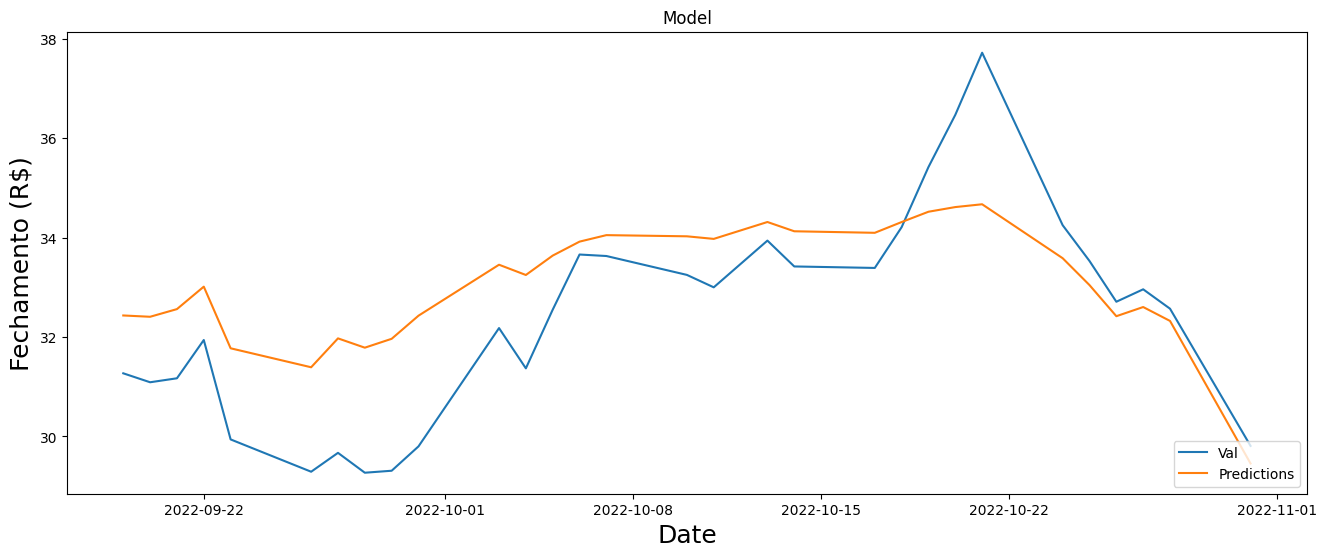

In [402]:
# plotar o resultado dos testes nos ultimos 30 dias
total = petr_dados_formatado.shape[0]
diasAnteriores = 30
predictions = model.predict(petr_dados_formatado[total-diasAnteriores:])
#train = petr_dados[:200]
valid = petr_dados[total-diasAnteriores:]
valid['predictions'] = predictions * max_close
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Fechamento (R$)', fontsize=18)
#plt.plot(train['Close'])
plt.plot(valid[['close', 'predictions']])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()


4/4 [==============================] - 0s 11ms/step


C:\Users\gabri\AppData\Local\Temp\ipykernel_21936\2984961114.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions * max_close


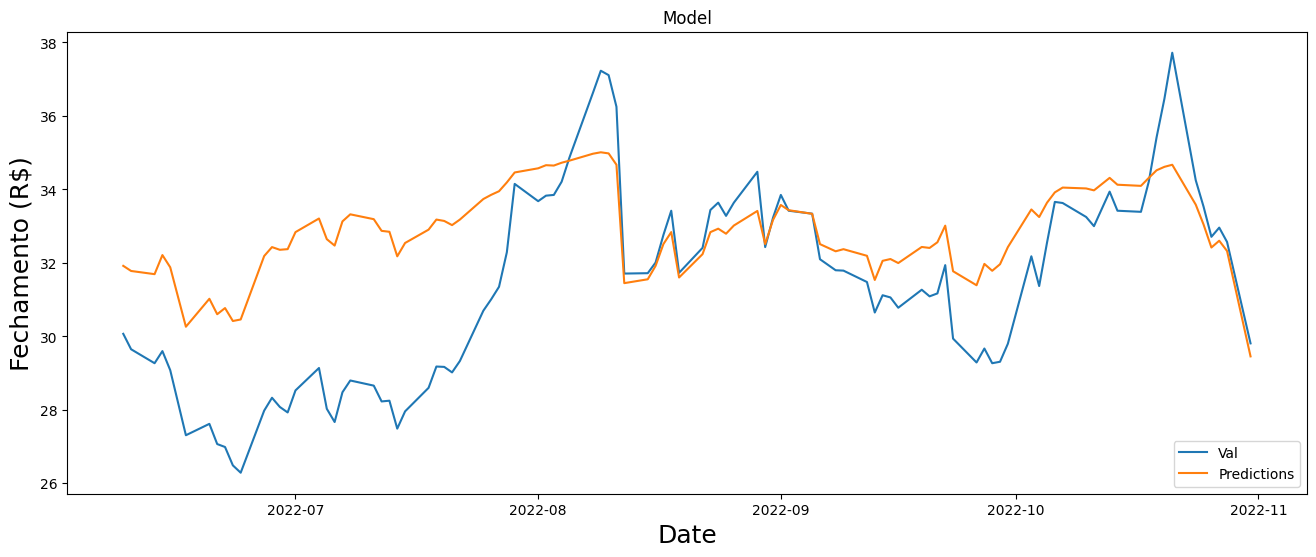

In [403]:
# plotar o resultado dos testes nos ultimos 100 dias
total = petr_dados_formatado.shape[0]
diasAnteriores = 100
predictions = model.predict(petr_dados_formatado[total-diasAnteriores:])
#train = petr_dados[:200]
valid = petr_dados[total-diasAnteriores:]
valid['predictions'] = predictions * max_close
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Fechamento (R$)', fontsize=18)
#plt.plot(train['Close'])
plt.plot(valid[['close', 'predictions']])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()

22/22 [==============================] - 0s 12ms/step


C:\Users\gabri\AppData\Local\Temp\ipykernel_21936\1254132064.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['predictions'] = predictions * max_close


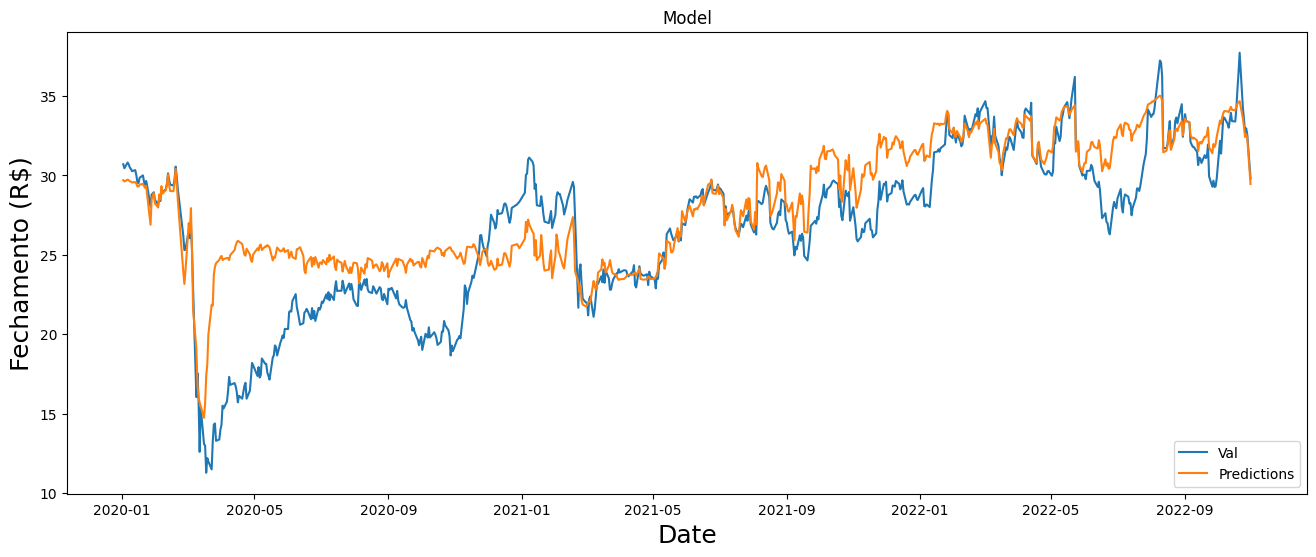

In [404]:
# plotar o resultado dos testes 
total = petr_dados_formatado.shape[0]
diasAnteriores = total
predictions = model.predict(petr_dados_formatado[total-diasAnteriores:])
#train = petr_dados[:200]
valid = petr_dados[total-diasAnteriores:]
valid['predictions'] = predictions * max_close
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Fechamento (R$)', fontsize=18)
#plt.plot(train['Close'])
plt.plot(valid[['close', 'predictions']])
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()

In [363]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.version)

Num GPUs Available:  1
<module 'tensorflow._api.v2.version' from 'C:\\Users\\gabri\\AppData\\Roaming\\Python\\Python310\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>
